In [1]:
### Think X as a six-dimensional vector
### Every date(T) has 6 features - High, Low, Open, Close, Volume, ADJ Close.
### Predict the specific feature of the next day if the data is entered by 6 * n

In [2]:
import pandas as pd # Load CSV file road 
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np # Matrix Operations 
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt # Data visualization 

print (torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.10.2+cpu
Populating the interactive namespace from numpy and matplotlib


# Pandas Datareader Test

In [3]:
## stock price over the past 3 years, starting on Jan 1, 2019
start = (2019,1,1)
start = datetime.datetime(*start)
end = datetime.date.today()

google = pdr.DataReader('GME', 'yahoo', start, end)

<AxesSubplot:xlabel='Date'>

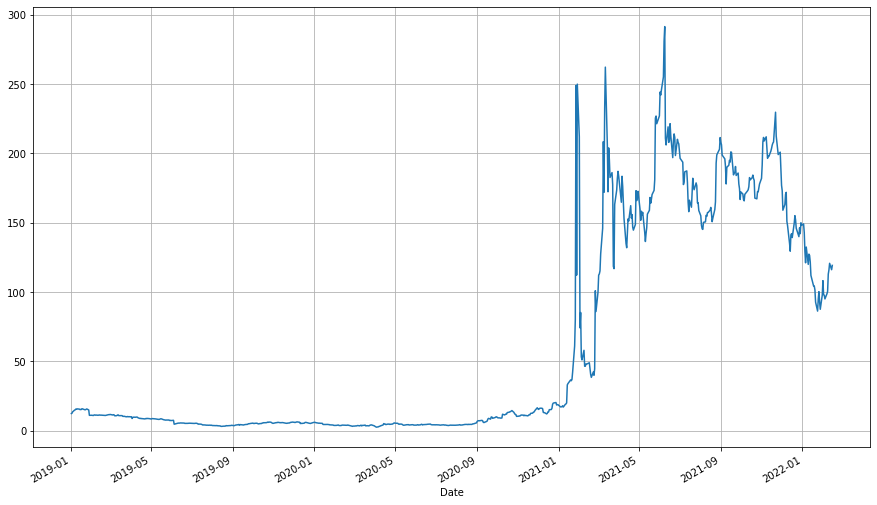

In [4]:
google.Low.plot(grid = True)

# Data Preparation

In [5]:
#### To-Do: Train to make predictions from T+1 to T+5 at the same time
##### -> If only T + 1 is predicted, it will be taught to predict the same price as the previous day's

## Dataset -> to give the i-th record value.

class StockDataset(Dataset):
    ## X is a sequence of the price fluctuations
    ## Y is a sequence of the specific feature (Prediction of the next day)
    def __init__(self, symbol, x_frames, y_frames, start, end):
        ## x frames -> data of recemt n days
        ## y frames -> data of after n days
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)
        
        self.data = pdr.DataReader(self.symbol, 'yahoo', self.start, self.end)
        print (self.data.isna().sum())
    
    # Dataset size return 
    ## -> To know how big the dataset is, when a dataset makes a batch
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1

    # When the i-th of the dataset is called, return the x and y values corresponding to the i-th.
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx - self.x_frames:idx + self.y_frames]
        # Normarlization
        # Transform the x and y sequences by the difference between the log values of the last n days and the log values of each date.
        # For Numerical stability
        # TThe stock price is greater than 0.
        # Even if the data is accidentally missing and 0 comes into x, 
        # the value is 0 in the worst case because x is added by 1.
        data = data.apply(lambda x: np.log(x + 1) - np.log(x[self.x_frames - 1] + 1))
        data = data.values # convert the dataframe to numpy aray
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

# Model Define

In [6]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    # The function making MLP that changes hidden dimension to output dimension.
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    # After adding sequence to lstm, add h in t step to the regressor to predict the price
    def forward(self, x):
        # lstm_out -> The ht of the last layer to be sent to y.
        # self.hidden ->  has all hidden states in each layer
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        # lstm_out -> The output value of the lstm model in each time step.
        # lstm_out[-1] -> Predicting with the hidden vector after entering the last data (price).
        # Put the function of reshaping this in batch size into the regressor.
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [7]:
# Measures the average magnitude by the percentage of the errors of absolute value of the difference 
# between the predicted value and the actual stock price.
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values') # ㅁbsolute value of the difference
    return mae*100

# Train, Validate, Test

In [8]:
def train(model, partition, optimizer, loss_fn, args):
    # DataLoader(custom_dataset, automatically chunking batch size, shuffeling? using the last batch?)
    trainloader = DataLoader(partition['train'], 
                             batch_size = args.batch_size, 
                             shuffle = True, drop_last = True)
    
    model.train()
    # Initiate Gradients
    # Pytorch keeps adding gradients values to the backward later, 
    # so we always have to make the gradients 0 before backpropagation.
    model.zero_grad()
    optimizer.zero_grad()

    # Initiate accuracy and loss
    train_acc = 0.0 # value of the metric
    train_loss = 0.0
    
    # Samples how many records to assign to the first batch through sampler.
    for i, (X, y) in enumerate(trainloader):
        
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device) # select only 'Close(3rd)' feature

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [9]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [10]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [11]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment

In [12]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df


In [13]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [14]:
!mkdir results

In [15]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = 'GME'
args.batch_size = 128
args.x_frames = 5
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 2


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]

trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2019,1,1), (2020,10,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2020,10,1), (2021,6,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2021,6,1), (2022,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
Namespace(batch_size=128, device='cpu', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=1, optim='RMSprop', symbol='GME', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 15.85/11.88, Loss(train/val) 0.03868/0.14953. Took 3.32 sec
Epoch 1, Acc(train/val): 6.37/12.00, Loss(train/val) 0.01324/0.14905. Took 3.06 sec
Namespace(batch_size=128, device='cpu', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=2, optim='RMSprop', symbol='GME', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 19.96/16.85, Loss(train/val) 0.07663/0.15052. Took 3.10 sec
Epoch 1, Acc(train/val)

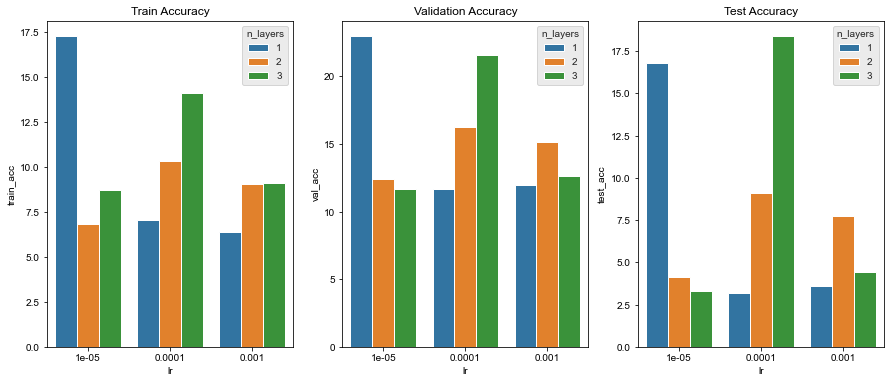

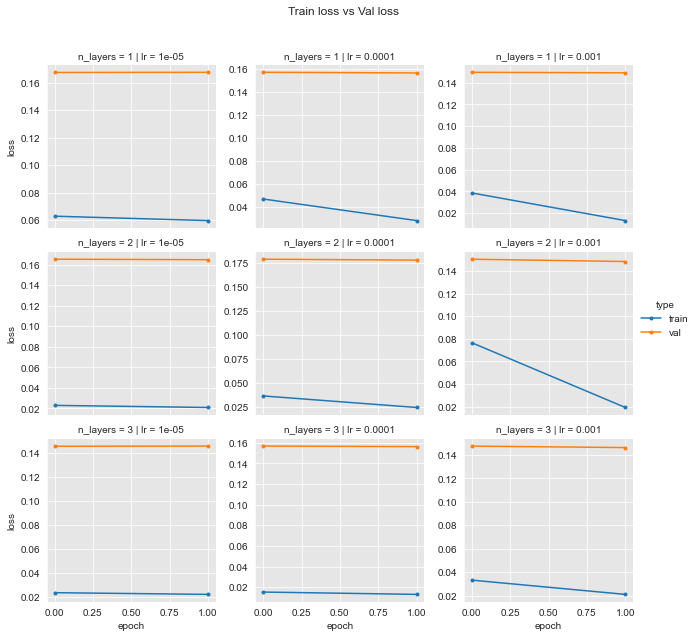

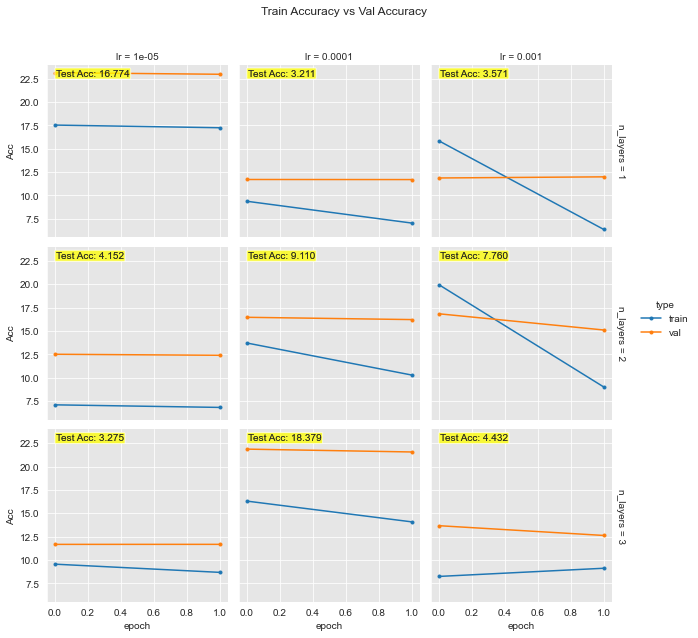

In [16]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) # If sharey is True, the y-axis scale of all subplots will be the same.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)